In [1]:
from google.colab import files
uploaded = files.upload()

Saving ner1.csv to ner1.csv


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

data = pd.read_csv(io.BytesIO(uploaded['ner1.csv']),encoding="latin1").fillna(method="ffill")
data.tail(10)

,Sentence #,Word,Tag
2337,Sentence: 111,and,o
2338,Sentence: 111,20-10-2019,deliveryToDate
2339,Sentence: 111,.,o
2340,Sentence: 112,buy,contractType
2341,Sentence: 112,oats,productId
2342,Sentence: 112,from,o
2343,Sentence: 112,Australia,originationCountryId
2344,Sentence: 112,to,o
2345,Sentence: 112,China,destinationCountryId
2346,Sentence: 112,.,o


In [17]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

131

In [18]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

25

In [19]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,  t) for w,  t in zip(s["Word"].values.tolist(),
                                                           
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [20]:
getter = SentenceGetter(data)

In [21]:
sent = getter.get_next()

In [22]:
sent

[('Buy', 'contractType'),
 ('200', 'itemQty'),
 ('MT', 'itemQtyUnitId'),
 ('cotton', 'productId'),
 ('of', 'o'),
 ('quality', 'o'),
 ('Cotton-A-Dry', 'quality'),
 ('with', 'o'),
 ('tolerance', 'o'),
 ('2', 'tolerance'),
 ('%', 'toleranceType'),
 ('buyer', 'toleranceLevel'),
 ('at', 'o'),
 ('120', 'priceDf'),
 ('USD/MT', 'priceUnitId'),
 ('flat', 'priceTypeId'),
 (',', 'o'),
 ('settled', 'o'),
 ('in', 'o'),
 ('AUD', 'payInCurId'),
 ('.', 'o')]

In [23]:
sentences = getter.sentences

In [24]:
max_len = 50
tag2idx = {t: i for i, t in enumerate(tags)}

In [25]:
X = [[w[0] for w in s] for s in sentences]

In [26]:
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X = new_X

In [27]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [28]:
from keras.preprocessing.sequence import pad_sequences
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["o"])


Using TensorFlow backend.


In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=2018)

In [54]:
batch_size = 25

In [55]:
import tensorflow as tf
import tensorflow_hub as hub
# from keras import backend as K
import tensorflow.python.keras.backend as K

In [56]:
sess = tf.compat.v1.Session()
# K.set_session(sess)

In [57]:
elmo_model = hub.load("https://tfhub.dev/google/elmo/2")
# sess.run(tf.global_variables_initializer())
# sess.run(tf.tables_initializer())

In [58]:
def ElmoEmbedding(x):
    return elmo_model.signatures["tokens"](tokens=tf.squeeze(tf.cast(x, tf.string)), sequence_len=tf.constant(batch_size*[max_len]))["elmo"]

In [ ]:
# # DEPRECATED: TensorFlow 1
# m = hub.Module(handle, tags={"foo", "bar"})
# tensors_out_dict = m(dict(x1=..., x2=...), signature="sig", as_dict=True)
# # TensorFlow 2
# m = hub.load(path, tags={"foo", "bar"})
# tensors_out_dict = elmo_model.signatures["tokens"](tokens=tf.squeeze(tf.cast(x, tf.string)), sequence_len=tf.constant(batch_size*[max_len])

In [59]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [60]:
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(None, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

In [61]:
model = Model(input_text, out)

In [62]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [63]:
X_tr, X_val = X_tr[:90*batch_size], X_tr[-52*batch_size:]
y_tr, y_val = y_tr[:90*batch_size], y_tr[-52*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [64]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=5, verbose=1)

Train on 100 samples, validate on 100 samples
Epoch 1/5
100/100 [==============================] - 38s 382ms/step - loss: 0.5507 - accuracy: 0.8622 - val_loss: 0.0793 - val_accuracy: 0.9846
Epoch 2/5
100/100 [==============================] - 36s 361ms/step - loss: 0.0542 - accuracy: 0.9890 - val_loss: 0.0232 - val_accuracy: 0.9976
Epoch 3/5
100/100 [==============================] - 36s 361ms/step - loss: 0.0186 - accuracy: 0.9986 - val_loss: 0.0114 - val_accuracy: 0.9988
Epoch 4/5
100/100 [==============================] - 36s 361ms/step - loss: 0.0097 - accuracy: 0.9996 - val_loss: 0.0047 - val_accuracy: 0.9996
Epoch 5/5
100/100 [==============================] - 36s 362ms/step - loss: 0.0057 - accuracy: 0.9992 - val_loss: 0.0028 - val_accuracy: 0.9992


In [66]:
hist = pd.DataFrame(history.history)

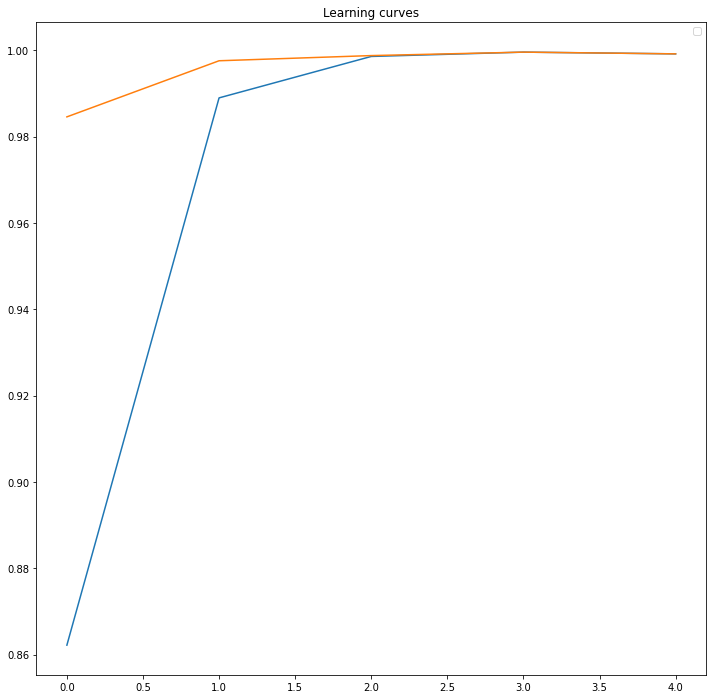

In [67]:
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Learning curves")
plt.legend()
plt.show()

In [ ]:
i = 19
p = model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "__PAD__":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))


In [96]:
p = model.predict(np.array(X_te[1:1+batch_size]))[0]

In [97]:
p = np.argmax(p, axis=-1)

Word            Pred : (True)


In [100]:
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*1)
for w, true, pred in zip(X_te[1], y_te[1], p):
    if w != "__PAD__":
        print("{:1}:{:1} ({})".format(w, tags[pred], tags[true]))

Word            Pred : (True)
=
Sell:contractType (contractType)
20:itemQty (itemQty)
MT:itemQtyUnitId (itemQtyUnitId)
for:o (o)
flat:priceTypeId (priceTypeId)
price:o (o)
of:o (o)
200:priceDf (priceDf)
USD:payInCurId (payInCurId)
of:o (o)
Barley:productId (productId)
of:o (o)
quality:o (o)
Balie:quality (quality)
genie:quality (quality)
for:o (o)
Karthik:traderUserId (traderUserId)
Aradhya:traderUserId (traderUserId)
from:o (o)
Kirfjohl:cpProfileId (cpProfileId)
with:o (o)
21:paymentTermId (paymentTermId)
days:paymentTermId (paymentTermId)
with:o (o)
English:applicableLawId (applicableLawId)
Law:applicableLawId (applicableLawId)
at:o (o)
CIF:incotermId (incotermId)
.:o (o)


In [87]:
string = "buy from bangalore"
li = list(string.split(" "))
li

['buy', 'from', 'bangalore']

In [91]:
new_a = li + ["__PAD__"] * ( 50- len(li))

In [94]:
X_te[1]

['Sell',
 '20',
 'MT',
 'for',
 'flat',
 'price',
 'of',
 '200',
 'USD',
 'of',
 'Barley',
 'of',
 'quality',
 'Balie',
 'genie',
 'for',
 'Karthik',
 'Aradhya',
 'from',
 'Kirfjohl',
 'with',
 '21',
 'days',
 'with',
 'English',
 'Law',
 'at',
 'CIF',
 '.',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__']

In [90]:
p = model.predict(np.array(new_a))[0]

ValueError: ignored